## N-Gram Feature Inspection

This notebook looks explicity at ngram features and tries to identity clusters of the problem domain simply by looking at ngrams.

In [71]:
import sys
sys.path.append('../')
import pandas as pd
from importlib import reload
import libs.ml_features as mlf
import libs.ngrams as ng
import libs.utils as utils
import libs.stats as stats
import libs.feature_analysis as fa
import numpy as np
import spacy
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(style="ticks", color_codes=True)

In [35]:
## Import Dataset
df1_en = utils.load_dataframe(version=1,language='en')
nlp_en = spacy.load('en')

In [101]:
reload(mlf)
reload(ng)

ngram_feature_map = {
    "NGram_1_EV" : ng.create_feature(ng.evidence_ngram_score, ngram_size=1),
    "NGram_1_CF" : ng.create_feature(ng.confusion_ngram_score, ngram_size=1),
    "NGram_2_EV" : ng.create_feature(ng.evidence_ngram_score, ngram_size=2),
    "NGram_2_CF" : ng.create_feature(ng.confusion_ngram_score, ngram_size=2),
    "NGram_3_EV" : ng.create_feature(ng.evidence_ngram_score, ngram_size=3),
    "NGram_3_CF" : ng.create_feature(ng.confusion_ngram_score, ngram_size=3),
    "NGram_1" : ng.create_feature(ng.ngram_score, ngram_size=1),
    "NGram_2" : ng.create_feature(ng.ngram_score, ngram_size=2),
    "NGram_3" : ng.create_feature(ng.ngram_score, ngram_size=3)
}

ngram_features_df = mlf.feature_builder(df1_en, nlp_en, ngram_feature_map, logging=True)
reload(utils)
merged_df = utils.merge_dataframe(df1_en, ngram_features_df)

Features [100]: done.
Features [200]: done.
Features [300]: done.
Features [400]: done.
Features [500]: done.
Features [600]: done.


In [105]:
merged_df.describe()

AID         QID       Score         SID      Score4      Score3  \
count  630.000000  630.000000  630.000000  630.000000  630.000000  630.000000   
mean     1.977778    4.000000    4.058730   15.655556    2.130159    1.566667   
std      0.816843    2.001589    1.186052    8.881686    0.972865    0.656023   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%      1.000000    2.000000    3.500000    8.000000    2.000000    1.000000   
50%      2.000000    4.000000    4.500000   15.500000    2.000000    2.000000   
75%      3.000000    6.000000    5.000000   23.000000    3.000000    2.000000   
max      3.000000    7.000000    5.000000   31.000000    3.000000    2.000000   

           Score2  NGram_1_EV  NGram_1_CF  NGram_2_EV  NGram_2_CF  NGram_3_EV  \
count  630.000000  630.000000  630.000000  630.000000  630.000000  630.000000   
mean     0.907937    0.411736    0.342810    0.159632    0.137542    0.071914   
std      0.289345    0.262942    0.242205    0.225682    0.192136    0.164962   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.200000    0.142857    0.000000    0.000000    0.000000   
50%      1.000000    0.400000    0.333333    0.083333    0.075962    0.000000   
75%      1.000000    0.587010    0.500000    0.208333    0.187500    0.071429   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       NGram_3_CF     NGram_1     NGram_2     NGram_3  
count  630.000000  630.000000  630.000000  630.000000  
mean     0.060309    0.341071    0.132208    0.060422  
std      0.144504    0.220950    0.181911    0.140398  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.173913    0.000000    0.000000  
50%      0.000000    0.338095    0.076923    0.000000  
75%      0.051282    0.480000    0.185831    0.058403  
max      1.000000    1.000000    1.000000    1.000000

1. The high right cluster is answers 1.2, 2.5, 3.3 (Fill-In-The-Blank) Model Answer responses with very few characters.
2. Let's drop them and try to find other structure.

In [102]:
cmp = ngram_features_df.drop(['GID'], axis=1).copy()
idxs = ~ngram_features_df['GID'].isin(['1.2', '2.5', '3.3'])
cmp = cmp[idxs]
cmp_scores = df1_en['Score4'][idxs]

In [103]:
res = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(cmp.as_matrix())

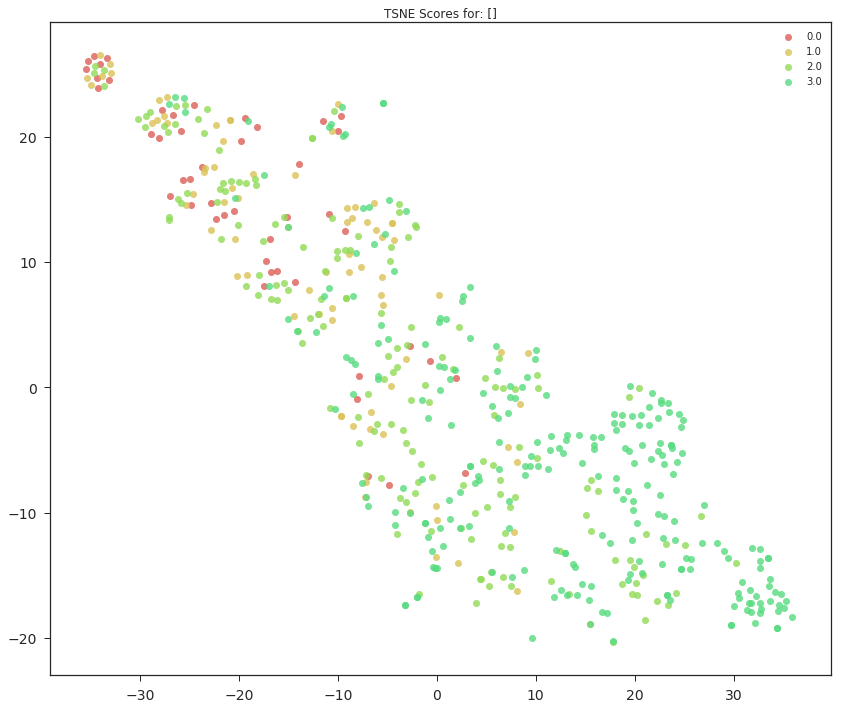

In [104]:
fa.plot_tsne(res, cmp_scores.as_matrix())

In [69]:
idxs2 = fa.select_indexes_from_tsne(merged_df[idxs], res, [-5,10], [18,35])
t1 = merged_df[idxs][idxs2]
t1[np.logical_and(t1['Score'] > 4, t1['NGram_2_EV'] > 0)]

AID  QID                                             Prompt  \
216    1    7  What are the similarities between iteration an...   
289    2    3  What is the difference between a constructor a...   
401    2    7                 What is the role of a header-file?   

                                          Model Answer  Score  SID  \
216  They both involve repetition; they both have t...    3.5   14   
289  A constructor is called whenever an object is ...    3.5   21   
401  To store a class interface, including data mem...    3.5    4   

                                        Student Answer  Score4  Score3  \
216  they both are able to do repetiive tasks. howe...     2.0     1.0   
289  A constructor initialized values at the execut...     2.0     1.0   
401  A header file consists of "reusable" source co...     2.0     1.0   

     Score2  GID  GID  NGram_1_EV  NGram_1_CF  NGram_2_EV  NGram_2_CF  \
216     1.0  1.7  1.7    0.200000    0.052632    0.083333    0.022222   
289     1.0  2.3  2.3    0.100000    0.166667    0.035714    0.076923   
401     1.0  2.7  2.7    0.181818    0.090909    0.090909    0.037037   

     NGram_3_EV  NGram_3_CF  
216         0.0         0.0  
289         0.0         0.0  
401         0.0         0.0

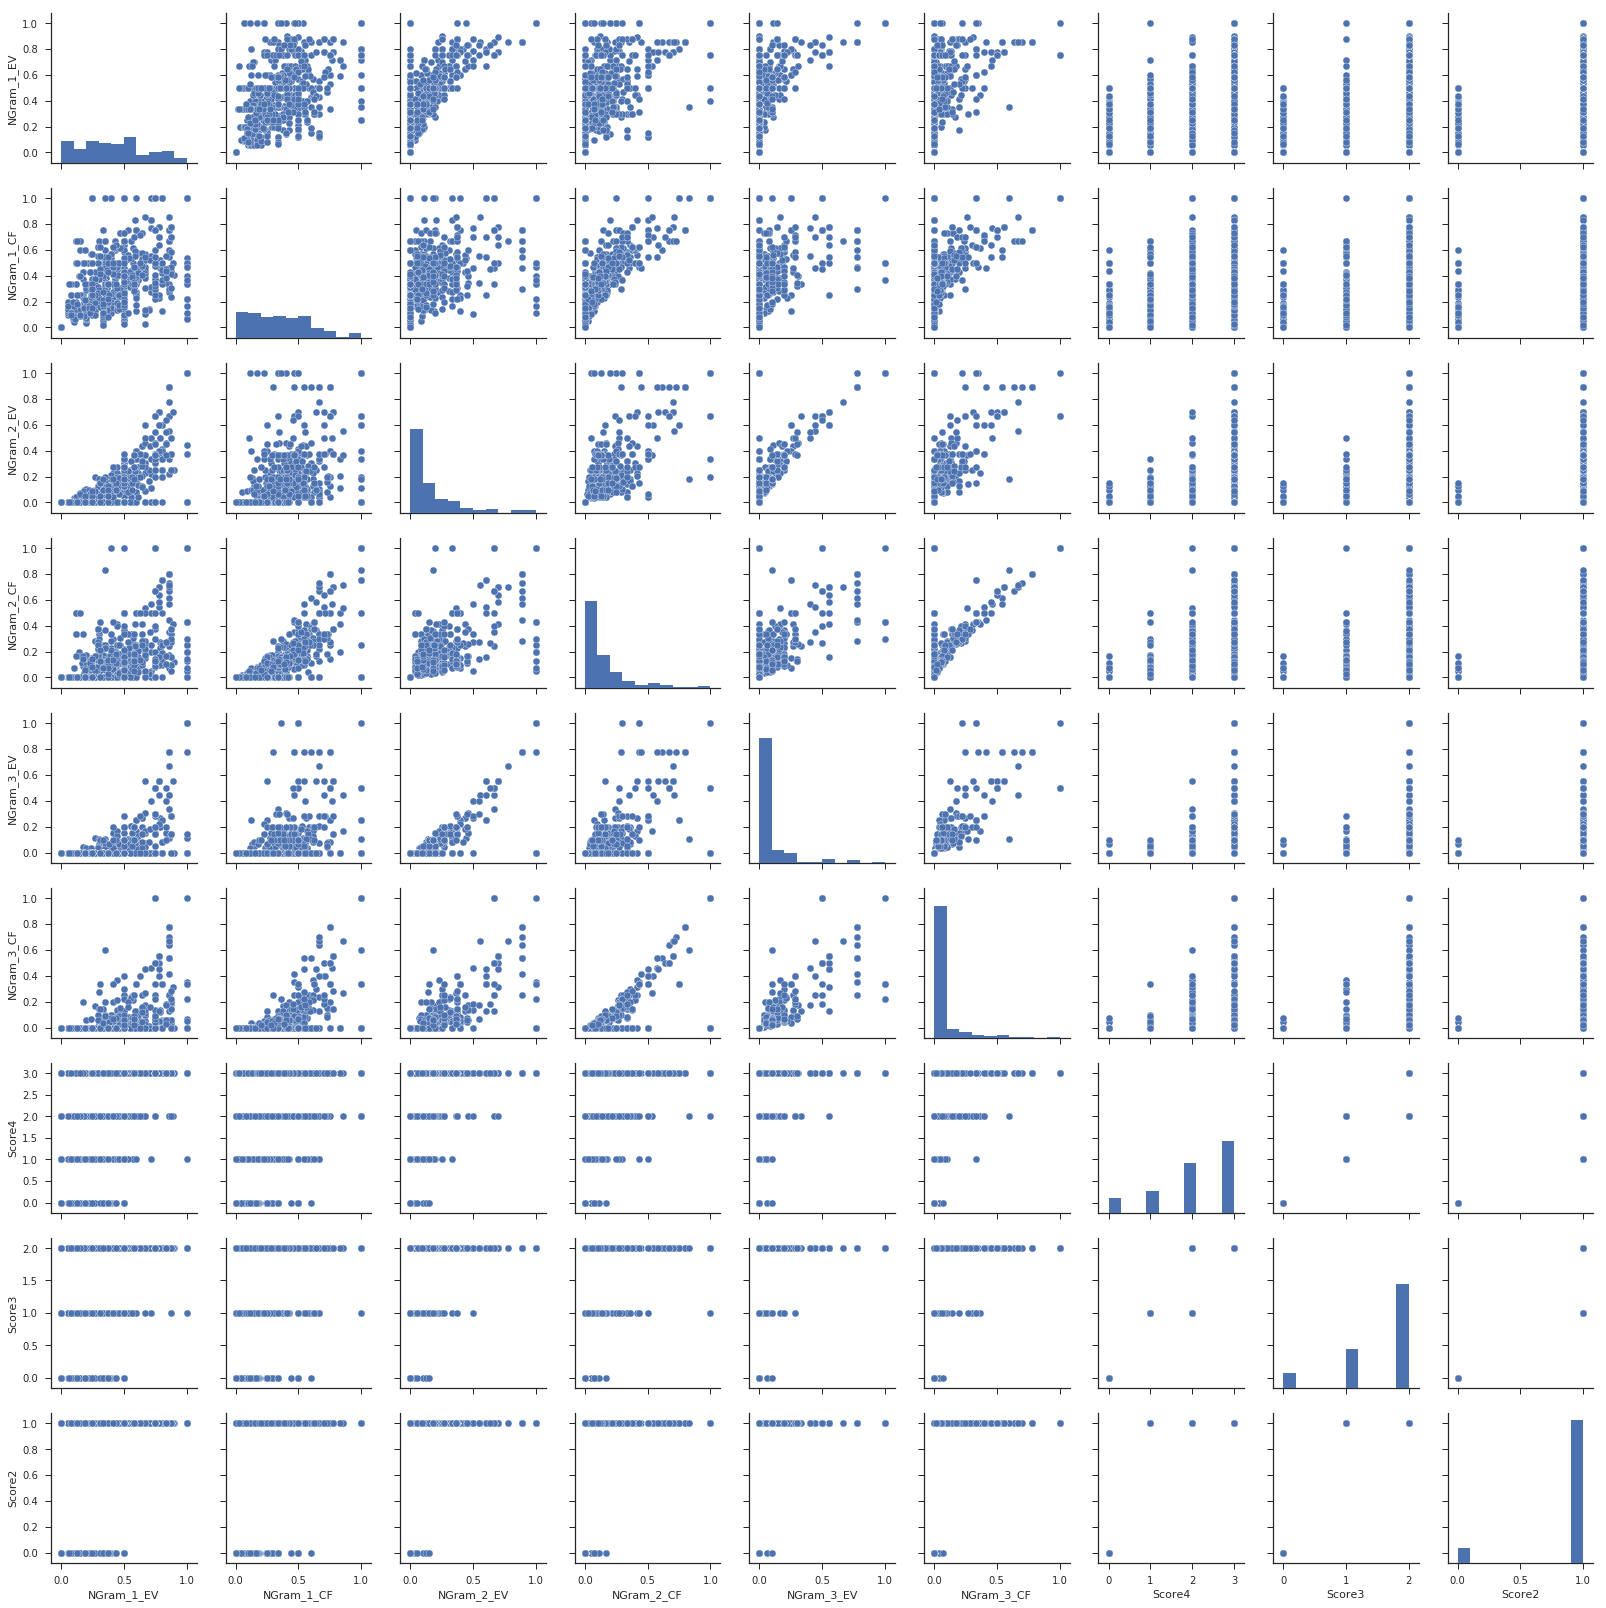

In [70]:
sns.pairplot(merged_df[['NGram_1_EV','NGram_1_CF','NGram_2_EV','NGram_2_CF','NGram_3_EV','NGram_3_CF','Score4','Score3','Score2']])

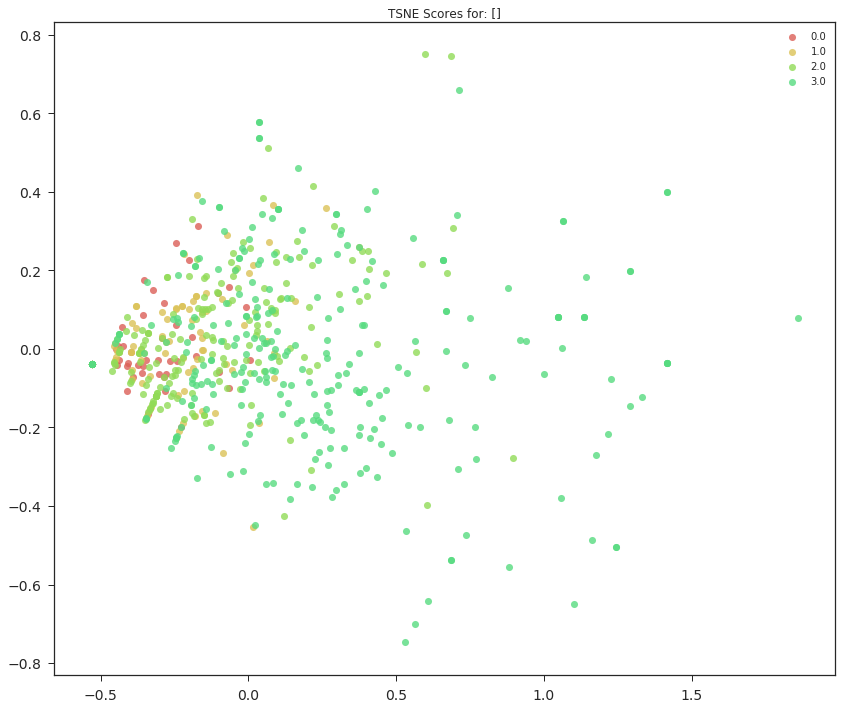

[0.694174   0.13646468]


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

comps = merged_df[['NGram_1_EV','NGram_1_CF','NGram_2_EV','NGram_2_CF','NGram_3_EV','NGram_3_CF']].as_matrix()
pca_values = pca.fit_transform(comps)
fa.plot_tsne(values, merged_df['Score4'])
print(pca.explained_variance_ratio_)

Accuracy: 57.143%
Precision: 45.733%
Recall: 57.143%
F1-Measure: 50.786%
Pearson's R: 0.48
Cohen's Kappa: 0.28
RMSE: 0.93
MAE: 0.57
Y-True Mean: 2.17
Y-Pred Mean: 2.57
Y-True Std Deviation: 0.96
Y-Pred Std Deviation: 0.50


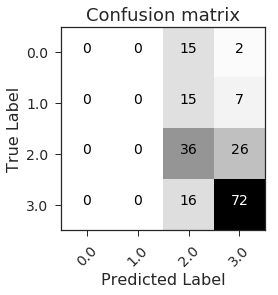

In [96]:
# How does just this feature boost the baseline?
reload(stats)
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

#clf = svm.SVC(kernel='rbf', gamma=0.5)
clf = RandomForestClassifier(n_estimators=100, max_depth=2)

train_x, test_x, train_y, test_y = train_test_split(pca_values, merged_df['Score4'].as_matrix(), random_state=42, test_size=0.3)
clf.fit(train_x, train_y)

y_pred = clf.predict(test_x)
stats.show_all_stats(test_y, y_pred)